In [2]:
import os 

import numpy as np
from scipy.integrate import odeint 
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
plt.style.use("seaborn-pastel")

# CSTR não Isotérmico

## Descrição do Problema

Um reator CSTR é utilizado em uma reação $A \overset{kC_A}{\rightarrow} B$ e possui as seguintes especificações: 


<br>


|   Variáveis   | Descrição               |       Valor        | Unidade      |
| :-----------: | :------------------------: | :----------------: | :--------: |
|      $F$      | Vazão Volumétrica                |       $1$        | $m^3/h$   |
| $C_{A,f}$  | Concentração de Alimentação      |        $10$         | $kmol/m^3$   |
|  $T_{f}$   | Temperatura Alimentação|       $298$        | $K$       |
|      $V$      | Volume do Reator            |       $1$        | $m^3$       |
|    $\rho$     | Massa específica          |       $1000$       | $kg/m^3$    |
|     $C_p$     | Capacidade Calorífica             |      $0.5$       | $kcal/kg/K$  |
| $-\Delta H_r$ | Calor de Reação          |   $5960$    | $kcal/kmol$  |
|     $E_a$     | Energia de Ativação         |      $11843$       | $cal/mol$  |
|     $k_0$     | Fator de Frequência          | $3.493\times10^{7}$ | $h^{-1}$  |
|     $UA$      | Coeficiente de Troca Térmica |   $150$    | $kcal/h/K$ |
|     $T_c$     | Temperatura Água de Resfriamento       |       $298$        | $K$      |




## Modelagem

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/be/Agitated_vessel.svg/512px-Agitated_vessel.svg.png)


Considerando: 

- Volume constante $\rightarrow F_{entrada} = F_{saida} = F$
- Mistura perfeita
- Resistência condutiva desprezível
- Propriedades constantes

Tem-se

### Balanço para Componente A:


$$
\begin{align}
\dfrac{dVC_A}{dt} &=  FC_{A,f} - FC_A - kC_A \\
\dfrac{dC_A}{dt} &= \dfrac{F}{V}(C_{A,f} - C_A) - kC_A
\end{align}
$$

Onde:

$$k = k_0exp\left (\dfrac{-E_a}{RT} \right)$$


### Balanço de Energia:


$$\dfrac{d\rho V h}{dt} = \rho F h_f - \rho F h + kC_A V(-\Delta H_r) + UA(T_c - T)$$

<br>
Sabendo que $h = C_pT$:

<br>

<br>

$$
\begin{align}
\rho V C_P  \dfrac{dT}{dt} &= \rho C_P F(T_f - T) + kC_A V(-\Delta H_r) + UA(T_c - T) \\ 
\dfrac{dT}{dt} &= \dfrac{F}{V}(T_f - T) + \dfrac{(-\Delta H_r)}{\rho C_P} k C_A + \dfrac{UA}{\rho C_P V}(T_c - T)
\end{align}
$$

<br>

### Modelo Final:

$$
\begin{align}
\dfrac{dC_A}{dt} &= \dfrac{F}{V}(C_{A,f} - C_A) - kC_A \\ 
\dfrac{dT}{dt} &= \dfrac{F}{V}(T_f - T) + \dfrac{(-\Delta H_r)}{\rho C_P} k C_A + \dfrac{UA}{\rho C_P V}(T_c - T)
\end{align}
$$

<br>

## Estados Estacionários

No estado estacionário não temos dependência do tempo, logo: 

<br>


$$
\begin{align}
0 &= \dfrac{F}{V}(C_{A,f} - C_A) - kC_A \\ 
0 &= \dfrac{F}{V}(T_f - T) + \dfrac{(-\Delta H_r)}{\rho C_P} k C_A + \dfrac{UA}{\rho C_P V}(T_c - T)
\end{align}
$$

Isolando $C_A$ em ambas equações: 

<br>

$$
\begin{align}
C_{A,I} &= \dfrac{C_{A,f}}{\left [1+\dfrac{k_0exp \left ( \dfrac{-Ea}{RT} \right ) }{F/V} \right ]} \\ 
\\
C_{A, II} &= \dfrac{\dfrac{F}{V}(T - T_f) - \dfrac{UA}{\rho C_P V}(T_c - T)}{\dfrac{(-\Delta H_r)}{\rho C_P} k_0exp \left ( \dfrac{-Ea}{RT} \right )} 
\end{align}
$$

Quando $C_{A,I}=C_{A,II}=C_{A,EE}$  significa que ambas as derivdas são iguais a zero e encontramos um ponto de estado estacionário.

<br>

### Achando Estados Estacionários

In [3]:
# Atribuindo variáveis fixas
F = 1
V =  1
Cf = 10
Tf = 298
Tc = 298
Cp = 5
rho = 100
UA = 150
Ea = 11843
k0 = 3.493e7
dH = -5960
k = lambda x: k0*np.exp(-Ea/1.988/x)

In [4]:
def CSTR_nullclines(T):
  """
  Função para descobrir condições estacionárias do CSTR.
  """
  dCdt = F/V*Cf / (F/V + k(T))
  dTdt = ((UA/V/rho/Cp)*(T-Tc) - F/V*(Tf-T)) / ((-dH/rho/Cp)*k(T))

  plt.plot(T, dCdt, "-k", label="dCdt")
  plt.plot(T, dTdt, "--r", label="dTdt")
  plt.xlabel("Temperatura (K)", fontsize=15)
  plt.ylabel("Concentração (kmol/m³)", fontsize=15)
  plt.legend(loc="best", fontsize=15)
  plt.title("CSTR Nullclines", fontsize=20)

  return dCdt,dTdt

In [5]:
def CSTR(y,t):
  """
  Função que será utilizada para realizar a simulação dinâmica do
  CSTR.
  """
  C, T = y

  dC = F/V*(Cf-C) - k(T)*C
  dT = F/V*(Tf-T) + (-dH/rho/Cp)*k(T)*C - (UA/V/rho/Cp)*(T-Tc)

  return [dC, dT]

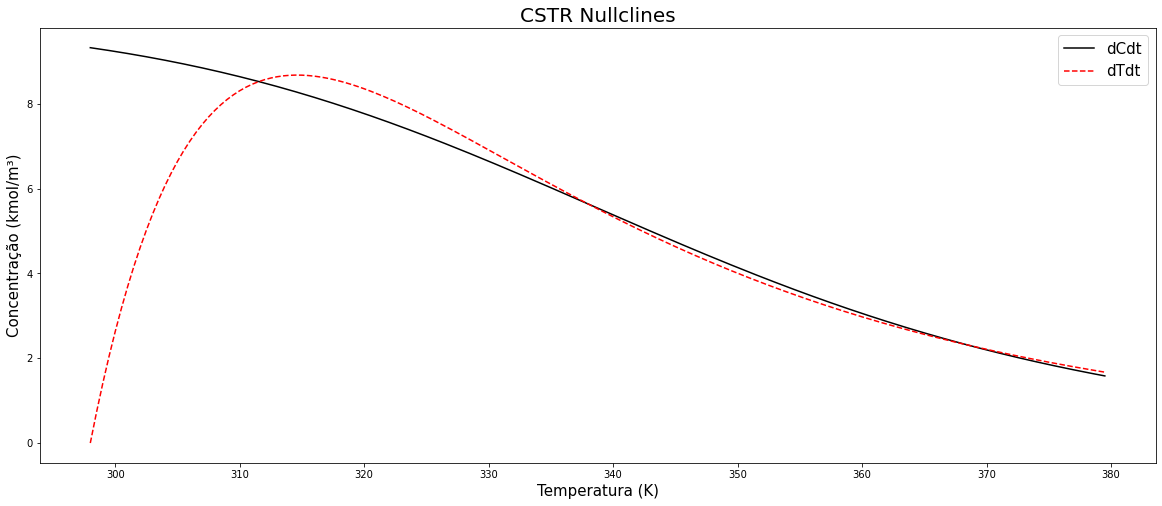

In [6]:
T = np.arange(298, 380, 0.5)
plt.figure(figsize=(20,8))
C1,C2 = CSTR_nullclines(T)

In [7]:
EE1 = fsolve(CSTR, [8, 310], args=(1,)).tolist()
EE2 = fsolve(CSTR, [5, 340], args=(1,)).tolist()
EE3 = fsolve(CSTR, [2, 370], args=(1,)).tolist()

EEs = [EE1, EE2, EE3]

### Simulação Dinâmica 

In [8]:
t_span = np.linspace(0, 10, 1001)
y0 = [3, 370]
y = odeint(CSTR, y0, t_span) 

In [9]:
# Selecionando valores de C
C = y[:, 0]
# Selecionando valores de T
T = y[:, 1]
# Selecionando Ca e T ao mesmo tempo
C, T = y.T

Text(0.5, 0, 'Tempo (h)')

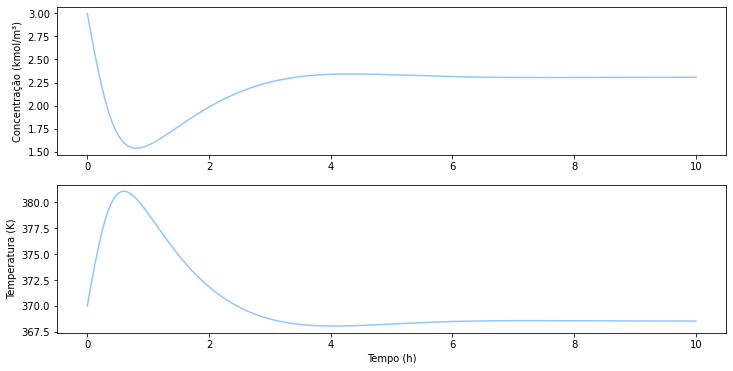

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(t_span, C)
plt.ylabel("Concentração (kmol/m³)")
plt.subplot(2,1,2)
plt.plot(t_span, T)
plt.ylabel("Temperatura (K)")
plt.xlabel("Tempo (h)")

Text(0.5, 1.0, 'Plano de Fases')

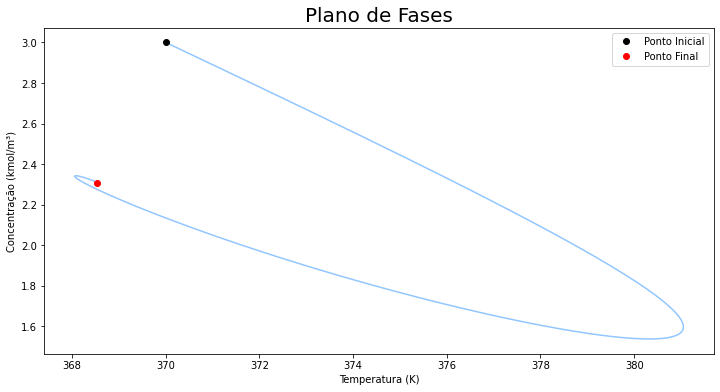

In [11]:
plt.figure(figsize=(12,6))
plt.plot(T, C)
plt.plot(y0[1], y0[0], "ok",label="Ponto Inicial")
plt.plot(EE3[1], EE3[0], "or",label="Ponto Final")
plt.ylabel("Concentração (kmol/m³)")
plt.xlabel("Temperatura (K)")
plt.legend(loc="best")
plt.title("Plano de Fases", fontsize=20)

### Simulando para Diversas Condições Iniciais.

In [12]:
CIs = [
       [10, 300], 
       [5, 300], 
       [9, 330], 
       [2, 330], 
       [6, 360], 
       [1, 360], 
       [7, 370], 
       [1, 380],
       [8, 380],
       [5.67, 339]
      ]

resultados = []

for CI in CIs:
  y = odeint(CSTR, CI, t_span)
  resultados.append(y.T)

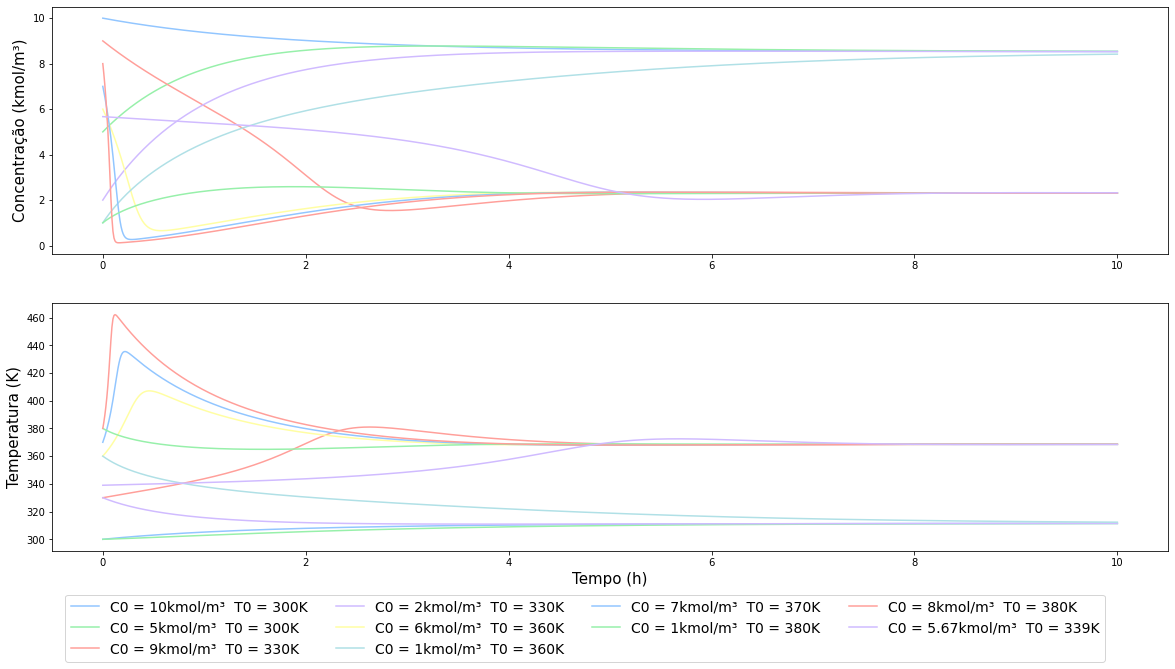

In [18]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
for idx, (C0, T0) in enumerate(CIs):
  C, _ = resultados[idx]
  plt.plot(t_span, C, label=f"C0 = {C0}kmol/m³ T0 = {T0}K")
plt.ylabel("Concentração (kmol/m³)", fontsize=15)
plt.xlabel("")

plt.subplot(2,1,2)
for idx, (C0, T0) in enumerate(CIs):
  _, T = resultados[idx]
  plt.plot(t_span, T, label=f"C0 = {C0}kmol/m³  T0 = {T0}K")
plt.ylabel("Temperatura (K)", fontsize=15)
plt.xlabel("Tempo (h)", fontsize=15)
plt.legend(bbox_to_anchor=(0.95, -0.15), ncol=4, fontsize=14)

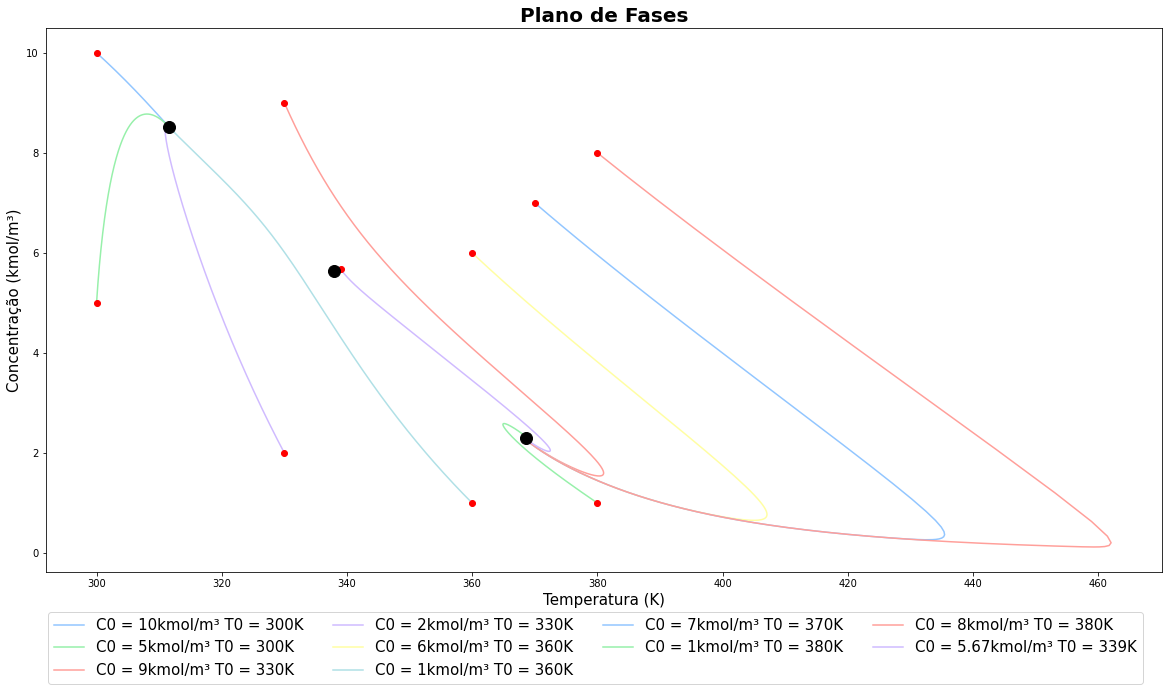

In [29]:
plt.figure(figsize=(20,10))
for idx, (C0, T0) in enumerate(CIs):
  C, T = resultados[idx]
  plt.plot(T, C, label=f"C0 = {C0}kmol/m³ T0 = {T0}K")
  plt.plot(T0, C0, 'or')
for EE in EEs:
  C_EE, T_EE = EE
  plt.plot(T_EE, C_EE, 'ok', markersize=12)
plt.ylabel("Concentração (kmol/m³)", fontsize=15)
plt.xlabel("Temperatura (K)", fontsize=15)
plt.title("Plano de Fases", fontsize=20, fontweight="bold")
plt.legend(fontsize=15, bbox_to_anchor=(0.99, -0.06), ncol=4)

### Animando as coisas

In [30]:
from matplotlib.animation import FuncAnimation
from IPython import display

In [31]:
fig = plt.figure(figsize=(20,8))

# Range de temperatura e concentração
T = np.linspace(290, 480, 32)
C = np.linspace(-0.3, 10.5, 32)
# Criando Grid
T, C = np.meshgrid(T, C)
# Calculando Derivadas
dC, dT = CSTR([C, T], t=0)
# Calculando Modulo e normalizando vetores
Mod = np.sqrt(dT**2 + dC**2)
dTnorm = dT / Mod;
dCnorm = dC / Mod;
# Plotando campo vetorial
Q = plt.quiver(T, C, dTnorm, dCnorm, Mod, units='width', cmap="viridis")

lines = [] 
points = []
# Loop para criar linhas e pontos e adicionar-los nas listas
for idx, (C0, T0) in enumerate(CIs):
  C, T = resultados[idx]
  line, = plt.plot([], [], label=r"$C_0$ = {} kmol/m³ $T_0$ = {} K".format(C0, T0), linewidth=3)
  point, = plt.plot(T[0], C[0], "ko", alpha=0.5, markersize=12)
  plt.plot(T0, C0, 'or', markersize=12)
  lines.append(line)
  points.append(point)

# Adicionando pontos do EE
for EE in EEs:
  C_EE, T_EE = EE
  plt.plot(T_EE, C_EE, 'ok', markersize=12)

plt.xlabel("Temperature (K)", fontsize=15)
plt.ylabel("Concentração (kmol/m³)", fontsize=15)
plt.title("Plano de Fases", fontsize= 20, fontweight="bold")
plt.xlim([290, 480])
plt.ylim([-0.3, 10.5])
plt.legend(loc="best", fontsize=13)


plt.tight_layout()
plt.close()

def animate(i):
  for idx, (line, point) in enumerate(zip(lines,points)):
    C, T = resultados[idx]
    line.set_data(T[:i], C[:i])
    point.set_data(T[i], C[i])

In [ ]:
anim = FuncAnimation(fig,animate,frames=len(t_span),interval=20)
anim.save("Plano_de_Fase_Animação.mp4", writer="ffmpeg")
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

### Degrau na Temperatura de Resfriamento



In [33]:
def CSTR_para_step(y, t, Tc):
  """
  Função que será utilizada para realizar a simulação dinâmica do
  CSTR.
  """
  C, T = y

  dC = F/V*(Cf-C) - k(T)*C
  dT = F/V*(Tf-T) + (-dH/rho/Cp)*k(T)*C - (UA/V/rho/Cp)*(T-Tc)

  return [dC, dT]

In [34]:
t = np.linspace(0, 20, 1001)
Tcs = []
for ts in t:
  if 6 < ts < 6.5:
    Tcs.append(298 + 24*(ts-6))
  elif 6.5 <= ts < 7:
    Tcs.append(310 - 24*(ts-6.5))
  else:
    Tcs.append(298)
y0 = [3, 370]

In [35]:
C = [y0[0]]
T = [y0[1]]

for i in range(1, len(t)):
  dt = [t[i-1], t[i]]
  y = odeint(CSTR_para_step, y0, dt, args=(Tcs[i-1],))
  C_dummy, T_dummy = y.T
  y0 = [C_dummy[-1], T_dummy[-1]]
  C.append(y0[0])
  T.append(y0[1])

Text(0.5, 0, 'Tempo (h)')

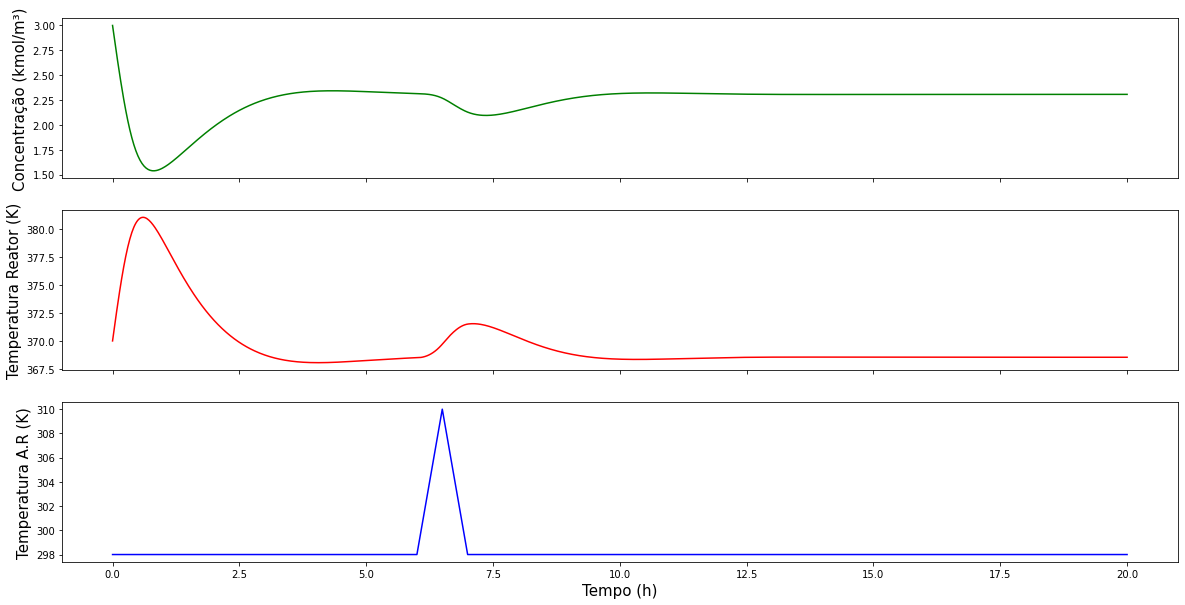

In [37]:
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(t, C, color="green")
plt.ylabel("Concentração (kmol/m³)", fontsize=15)
plt.xticks(color="w")

plt.subplot(3,1,2)
plt.plot(t, T, color="red")
plt.xticks(color="w")
plt.ylabel("Temperatura Reator (K)", fontsize=15)

plt.subplot(3,1,3)
plt.plot(t, Tcs, color="blue")
plt.ylabel("Temperatura A.R (K)", fontsize=15)
plt.xlabel("Tempo (h)", fontsize=15)